In [ ]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from statistics import mean
import math
import statistics
from scipy import stats
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

#Pre-Processing

In [ ]:
#reading in Fashion MNIST Dataset from drive (you can replace this path with the path to your own dataset)

df = pd.read_csv("/content/drive/MyDrive/MedIX - Subtype Discovery Project/Data and Analysis/fashion-mnist_train.csv")

In [ ]:
#labels for this dataset
y = (df['label']).to_numpy()

#dropping labels so that it doesn't interfere with clustering
X = df.drop(['label'], axis = 1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


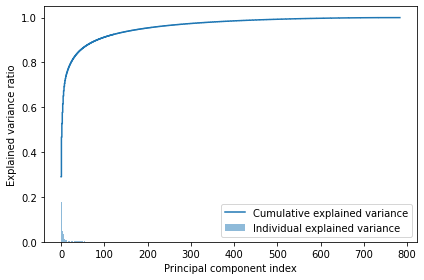

Best Number of Principal Components: 76


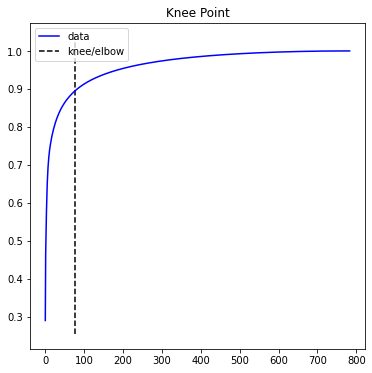

In [ ]:
#determining the best number of princial components to reduce the dimensions to

!pip install kneed
from kneed import KneeLocator


#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
X_pca = pca.fit_transform(X)



#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_

#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



kn = KneeLocator(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, curve = 'concave', direction = 'increasing')

kn.plot_knee()

print("Best Number of Principal Components: {}".format(kn.knee))



In [ ]:
#PCA to reduce the dimensions of Fashion MNIST

pca = PCA(n_components = 76) 
X = pca.fit_transform(X)

#Iterative Clustering

In [ ]:
#creating list of IDs for samples in dataset 
def createList(r1, r2):
    return [item for item in range(r1, r2)]
      
# Driver Code
r1, r2 = 0, len(list(df['label']))
lstOfIds = createList(r1, r2)

In [ ]:
#claclualtes the homogeneity per cluster
def calculateHomogeneity(predicted, actual, origNumLabels = 10):
  numPredictedClusters = len(np.unique(predicted)) # number of predicted clusters
  numActual = len(np.unique(actual)) # number of actual ground truth classes

  clusterHomogeneities = []
  clusterTotals = []
  for i in range(numPredictedClusters):
    homogeneityList = np.zeros(origNumLabels)
    # find all of the indices of the samples in each cluster 
    ind = np.where(np.isin(predicted,i))[0]
    actual = np.array(actual)
    actualVals = actual[ind] # finding the actual values in that cluster
    totalNumInCluster = len(actualVals) # finding the amount of points in that cluster
    clusterTotals.append(totalNumInCluster)
    for i in actualVals:
      homogeneityList[i] = homogeneityList[i] + 1
    homogeneityList = homogeneityList / totalNumInCluster
    clusterHomogeneities.append(max(homogeneityList))
  return [clusterHomogeneities, clusterTotals] 

In [ ]:
#iterative clusterin function; tries to remove at least one good cluster during each iteration
def iterativeClustering(threshold, data, actual, IdList, centers = [], properlyClassified = [], hsOfRemoved = [], lengthOfData = 60000):
 
  print("Number of data points to work with: ", data.shape[0])

  #finding the best k

  k = 1;
  currHomogeneity = 0.0;
  while (currHomogeneity < threshold and k <= math.sqrt(lengthOfData/2)):
    k = k + 1
    #print("K Value: ", k)
    model = sk.cluster.KMeans(n_clusters = k)
    clusterLabels = model.fit_predict(data)
    clusterCenters = model.cluster_centers_ # getting the centers of the clusters
    homogeneityList = calculateHomogeneity(clusterLabels, actual) 
    currHomogeneity = np.max(homogeneityList[0])
  

  predLabels = clusterLabels
  homogeneityPCluster = homogeneityList[0]
  
  for i in range(k):
    print("Homogeneity of cluster {} is {}".format(i,homogeneityPCluster[i]))
  
  #find clusters to remove
  clustersToRemove = []
  bestClusterHS = currHomogeneity
  print("this is max: {}".format(bestClusterHS))
  indexOfMax = homogeneityPCluster.index(bestClusterHS) 
  clusterTotals = homogeneityList[1]
  for i in range(k):
    diffBtwnBest = bestClusterHS - homogeneityPCluster[i]
    
    if i == indexOfMax:
      clustersToRemove.append(i)
      
      print("Cluster sectioned off:", i)
      continue
    if diffBtwnBest < .03 and homogeneityPCluster[i] >= threshold and clusterTotals[i]> math.sqrt(len(data)):
      
      clustersToRemove.append(i)
      
      print("Cluster sectioned off:", i)
    
  #so now we have clusters we want to remove
  #we need to calculate number of dpts in remaining clusters to determine if we stop

  pointsRemoved = 0
  totalPoints = sum(clusterTotals)
  for i in range(k):
    if i in clustersToRemove:
      pointsRemoved += clusterTotals[i] #clusterTotals in total points per cluster

  
  remainingDatapoints = totalPoints - pointsRemoved #check total points
  print("percent removed: {}".format(pointsRemoved/lengthOfData))
  if remainingDatapoints < math.sqrt(lengthOfData) or (pointsRemoved <= math.sqrt(len(data))): #need to check total points; needs to be constant variable; 
    print("DONE - we have all clusters")
    print("properly classified type: {}. Remaining type: {}".format(type(properlyClassified), type(data)))
    return list(properlyClassified), list(IdList), list(hsOfRemoved), list(centers)

  else: 
    #remove these dataPoints in cluster chosen to be separated
    #recluster remaining
    
    IdList = np.array(IdList)

    for num in clustersToRemove:
      indices = np.where(np.isin(predLabels,num))
      toAppend = IdList[indices]
      properlyClassified.append(toAppend)
      centers.append(clusterCenters[num])
      hsOfRemoved.append(homogeneityPCluster[num])
      data = np.delete(data, indices, axis=0)
      actual = np.delete(actual, indices) #axis=0
      IdList = np.delete(IdList,indices)
      predLabels = np.delete(predLabels,indices)
    
    print("Good clusters removed. Starting over with smaller dataset.")
    print("Length of properly classified: ", len(properlyClassified))
    count = 0
    for i in properlyClassified:
      print("Length of cluster {} : {}".format(count, len(i)))
      count = count + 1
    return iterativeClustering(threshold, data, actual,IdList, centers, properlyClassified, hsOfRemoved)

In [ ]:
separatedClusters, remainingPoints, scores, centers = iterativeClustering(0.8,X,y,lstOfIds)

Number of data points to work with:  60000
Homogeneity of cluster 0 is 0.6047883808010893
Homogeneity of cluster 1 is 0.21330441070137382
Homogeneity of cluster 2 is 0.5176676815204355
Homogeneity of cluster 3 is 0.8406654935210366
Homogeneity of cluster 4 is 0.916459697448634
Homogeneity of cluster 5 is 0.3697237145049885
Homogeneity of cluster 6 is 0.4557457212713936
this is max: 0.916459697448634
Cluster sectioned off: 4
percent removed: 0.07381666666666667
Good clusters removed. Starting over with smaller dataset.
Length of properly classified:  1
Length of cluster 0 : 4429
Number of data points to work with:  55571
Homogeneity of cluster 0 is 0.29846821379265004
Homogeneity of cluster 1 is 0.309512893982808
Homogeneity of cluster 2 is 0.8123982837697884
Homogeneity of cluster 3 is 0.3550244566899882
this is max: 0.8123982837697884
Cluster sectioned off: 2
percent removed: 0.11265
Good clusters removed. Starting over with smaller dataset.
Length of properly classified:  2
Length of

#Training/Testing classifier with subtypes from iterative clustering, traditional clusters (same number as the number of subtypes we got from iterative clustering), and ground truth classes

In [ ]:
#finds the ids of the samples in X-text (used to determine number of misclassified points)
def getIds(X_test):
  indexLst = []
  for lst in X_test:
    index = int(lst[-1])
    indexLst.append(index)
  return indexLst

In [ ]:
#find points misclassified in each cluster
def findMisclassified(X, X_test, y, y_test,listOfIndices): 
  numMisclassified = []
  indicesInX = listOfIndices #np.where(np.isin(predLabels,num))
  groundTruths = [y[i] for i in indicesInX]
  for i in np.unique(y_test):
    numMisclassifiedPerCluster = 0
    indicesOfInterest = np.where(y_test == i)[0]
    truthLabels = [groundTruths[i] for i in indicesOfInterest]
    majorityClassLabel = int(stats.mode(truthLabels)[0])
    for i in truthLabels:
      if i!=majorityClassLabel:
        numMisclassifiedPerCluster = numMisclassifiedPerCluster + 1
    numMisclassified.append(numMisclassifiedPerCluster)
  return numMisclassified

In [ ]:
def redefineXandY():
  df = pd.read_csv("/content/drive/MyDrive/MedIX - Subtype Discovery Project/Data and Analysis/fashion-mnist_train.csv")
  #labels for this dataset
  y = (df['label']).to_numpy()

  #dropping labels so that it doesn't interfere with clustering
  X = df.drop(['label'], axis = 1)
  pca = PCA(n_components = 76)
  X = pca.fit_transform(X)
  return X,y


In [ ]:
#creating labels for clusters from iterative clustering

labelsForEverything = np.zeros(60000)

labelForRemaining = len(separatedClusters)

for label in range(len(separatedClusters)):
  for index in separatedClusters[label]:
    labelsForEverything[index] = label


for index in remainingPoints: 
  labelsForEverything[index] = labelForRemaining

indices = np.where(labelsForEverything==labelForRemaining)
print(indices)

copyOfX = X
XRemoved = np.delete(copyOfX,indices[0],axis=0)

copyOfEverything = labelsForEverything
labelsForRemoved = np.delete(copyOfEverything,indices[0])

(array([    2,     5,     6, ..., 59986, 59987, 59989]),)


In [ ]:
#Classify MNIST into n classes with iterative clustering subtypes
X,y = redefineXandY()

r1, r2 = 0, len(list(y))
ids = createList(r1, r2)
X = pd.DataFrame(X)
X['ID'] = ids
X = X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, labelsForEverything, test_size = 0.2, stratify = labelsForEverything)
lstOfIndices = getIds(X_test)

X_train1 = []

for i in range(len(X_train)):
  everythingButLast = X_train[i][:-1]
  X_train1.append(everythingButLast)
    
  
X_train1 = np.array(X_train1)

X_test1 = []
for j in range(len(X_test)):
  X_test1.append(X_test[j][:-1])

X_test1 = np.array(X_test1)


svm = SVC()
svm.fit(X_train1, y_train)
svmResults = svm.predict(X_test1)
matrix = confusion_matrix(y_test, svmResults)
accuracies = matrix.diagonal()/matrix.sum(axis = 1)
print("Accuracies per class for our ITERATIVE subtypes: ", accuracies)
print("Overall accuracy for our ITERATIVE subtypes: ", accuracy_score(y_test, svmResults))
print("Recall for our ITERATIVE subtypes: ", recall_score(y_test, svmResults, average = 'macro'))
print("Recall for our ITERATIVE subtypes: ", recall_score(y_test, svmResults, average = None))
print("Precision for our ITERATIVE subtypes: ", precision_score(y_test, svmResults, average = 'macro'))
print("Precision for our ITERATIVE subtypes: ", precision_score(y_test, svmResults, average = None))
print("Number of points Misclassified per cluster: ", findMisclassified(X, X_test1, y, y_test,lstOfIndices))

Accuracies per class for our ITERATIVE subtypes:  [0.9785553  0.98372781 0.99168399 0.97576531 0.9595537  0.9713877
 0.94       0.91256831 0.95762712 0.82758621 0.83229814 0.85815603
 0.93382353 0.825      0.90243902 0.78082192 0.85542169 0.74074074
 0.92380952 0.97303762]
Overall accuracy for our ITERATIVE subtypes:  0.96325
Recall for our ITERATIVE subtypes:  0.9062001821104856
Recall for our ITERATIVE subtypes:  [0.9785553  0.98372781 0.99168399 0.97576531 0.9595537  0.9713877
 0.94       0.91256831 0.95762712 0.82758621 0.83229814 0.85815603
 0.93382353 0.825      0.90243902 0.78082192 0.85542169 0.74074074
 0.92380952 0.97303762]
Precision for our ITERATIVE subtypes:  0.9405359770907886
Precision for our ITERATIVE subtypes:  [0.98522727 0.98300074 0.97446374 0.98329049 0.96223776 0.96861626
 0.93377483 0.92265193 0.94428969 0.92307692 0.90540541 0.90977444
 0.92028986 0.94285714 0.888      0.91935484 0.8875     0.95238095
 0.94174757 0.96277969]
Number of points Misclassified per 

In [ ]:
print(mean([74, 249, 9, 165, 132, 118, 95, 26, 67, 4, 25, 22, 14, 16, 20, 2, 14, 10, 23, 3526])) #with unclustered
print(mean([74, 249, 9, 165, 132, 118, 95, 26, 67, 4, 25, 22, 14, 16, 20, 2, 14, 10, 23])) #without unclustered

230.55
57.10526315789474


In [ ]:
# Classify MNIST into ground truth classes (no clustering)
X,y = redefineXandY()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
svm = SVC()
svm.fit(X_train, y_train)
svmResults = svm.predict(X_test)
# at this point, we should have an accuracy metric
matrix = confusion_matrix(y_test, svmResults)
accuracies = matrix.diagonal()/matrix.sum(axis=1)
print("Accuracies per class for a simple SVM classifer: ", accuracies)
print("Overall accuracy for a simple SVM classifier: ", accuracy_score(y_test, svmResults))
print("Recall for a simple SVM classifier: ", recall_score(y_test, svmResults, average = 'macro'))
print("Precision for a simple SVM classifier: ", precision_score(y_test, svmResults, average = 'macro'))

Accuracies per class for a simple SVM classifer:  [0.8325     0.96916667 0.81083333 0.89166667 0.84583333 0.96
 0.6575     0.9525     0.97166667 0.9575    ]
Overall accuracy for a simple SVM classifier:  0.8849166666666667
Recall for a simple SVM classifier:  0.8849166666666667
Precision for a simple SVM classifier:  0.8844332919177684


In [ ]:
X,y = redefineXandY()


model = sk.cluster.KMeans(n_clusters = len(separatedClusters))
clusterLabels = model.fit_predict(X)

In [ ]:
#classifying MNIST into n classes using traditional k-means clusters



r1, r2 = 0, len(list(y))
ids = createList(r1, r2)
X = pd.DataFrame(X)
X['ID'] = ids
X = X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, clusterLabels, test_size = 0.2, stratify = clusterLabels)
lstOfIndices = getIds(X_test)

X_train1 = []

for i in range(len(X_train)):
  everythingButLast = X_train[i][:-1]
  X_train1.append(everythingButLast)
    
  
X_train1 = np.array(X_train1)

X_test1 = []
for j in range(len(X_test)):
  X_test1.append(X_test[j][:-1])

X_test1 = np.array(X_test1)

svm = SVC()
svm.fit(X_train1, y_train)
svmResults = svm.predict(X_test1)
matrix = confusion_matrix(y_test, svmResults)
accuracies = matrix.diagonal()/matrix.sum(axis = 1)
print("Accuracies per class for our TRADITIONAL subtypes: ", accuracies)
print("Overall accuracy for our TRADITIONAL subtypes: ", accuracy_score(y_test, svmResults))
print("Recall for our TRADITIONAL subtypes: ", recall_score(y_test, svmResults, average = 'macro'))
print("Precision for our TRADITIONAL subtypes: ", precision_score(y_test, svmResults, average = 'macro'))
print("Number of points Misclassified per cluster: ", findMisclassified(X, X_test1, y, y_test,lstOfIndices))


Accuracies per class for our TRADITIONAL subtypes:  [0.99860724 0.97342995 0.9753886  0.98827471 0.986733   0.96209588
 0.95035461 0.98099762 0.97847358 0.96806723 0.98977505 0.96632997
 0.94843962 0.98841699 0.97411765 0.98913043 0.9703154  0.97109827
 0.96343402]
Overall accuracy for our TRADITIONAL subtypes:  0.9743333333333334
Recall for our TRADITIONAL subtypes:  0.9749199903317594
Precision for our TRADITIONAL subtypes:  0.9739291632319198
Number of points Misclassified per cluster:  [1, 515, 221, 323, 59, 674, 386, 19, 116, 262, 13, 353, 373, 87, 19, 112, 329, 79, 350]


In [ ]:
print(mean([1, 515, 221, 323, 59, 674, 386, 19, 116, 262, 13, 353, 373, 87, 19, 112, 329, 79, 350]))

225.8421052631579


#Paper Results
##Class Distributions (Iterative vs Traditional Clustering)
##cluster center pictures

Average homogeneity for TRADITIONAL clustering:  0.693554303742272
this is class distribution for cluster 0
this is hs for cluster 0.718075422626788
Number of points of class Sandal in cluster 0: 2761 (71.80754226267881)
Number of points of class Bag in cluster 0: 145 (3.7711313394018204)
Number of points of class Sneaker in cluster 0: 886 (23.04291287386216)
Number of points of class Tshirt in cluster 0: 6 (0.15604681404421328)
Number of points of class Ankle Boot in cluster 0: 25 (0.6501950585175552)
Number of points of class Pullover in cluster 0: 6 (0.15604681404421328)
Number of points of class Shirt in cluster 0: 15 (0.3901170351105332)
Number of points of class Coat in cluster 0: 1 (0.02600780234070221)


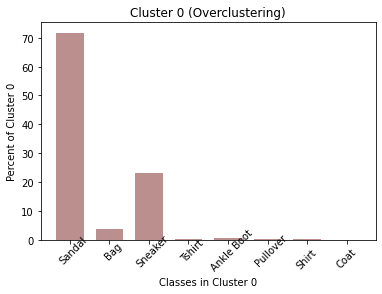

this is class distribution for cluster 1
this is hs for cluster 0.8159974707556118
Number of points of class Tshirt in cluster 1: 2581 (81.59974707556118)
Number of points of class Shirt in cluster 1: 517 (16.345241858994626)
Number of points of class Dress in cluster 1: 40 (1.2646221941195068)
Number of points of class Trouser in cluster 1: 2 (0.06323110970597534)
Number of points of class Pullover in cluster 1: 17 (0.5374644325007903)
Number of points of class Coat in cluster 1: 5 (0.15807777426493835)
Number of points of class Bag in cluster 1: 1 (0.03161555485298767)


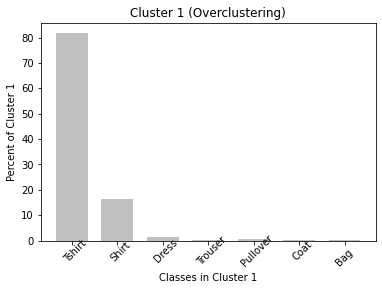

this is class distribution for cluster 2
this is hs for cluster 0.40983014094687387
Number of points of class Pullover in cluster 2: 1134 (40.983014094687384)
Number of points of class Shirt in cluster 2: 700 (25.29815684857246)
Number of points of class Coat in cluster 2: 483 (17.455728225515)
Number of points of class Tshirt in cluster 2: 142 (5.131911817853271)
Number of points of class Bag in cluster 2: 273 (9.86628117094326)
Number of points of class Trouser in cluster 2: 18 (0.6505240332490061)
Number of points of class Dress in cluster 2: 17 (0.6143838091796169)


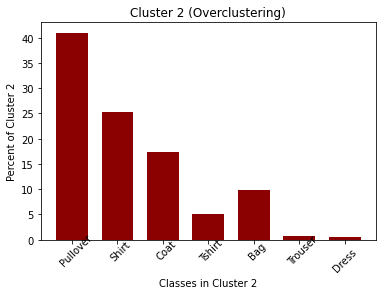

this is class distribution for cluster 3
this is hs for cluster 0.8477287268074216
Number of points of class Tshirt in cluster 3: 80 (2.5591810620601407)
Number of points of class Shirt in cluster 3: 18 (0.5758157389635317)
Number of points of class Dress in cluster 3: 2650 (84.77287268074217)
Number of points of class Bag in cluster 3: 23 (0.7357645553422905)
Number of points of class Coat in cluster 3: 45 (1.4395393474088292)
Number of points of class Trouser in cluster 3: 300 (9.596928982725528)
Number of points of class Ankle Boot in cluster 3: 3 (0.09596928982725528)
Number of points of class Sandal in cluster 3: 1 (0.03198976327575176)
Number of points of class Pullover in cluster 3: 6 (0.19193857965451055)


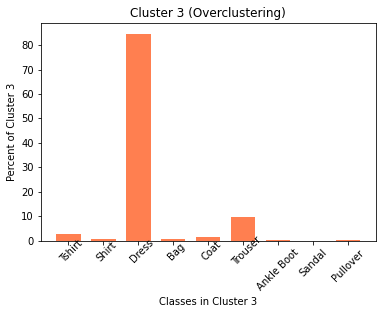

this is class distribution for cluster 4
this is hs for cluster 0.46664645239539115
Number of points of class Coat in cluster 4: 221 (6.701030927835052)
Number of points of class Tshirt in cluster 4: 1539 (46.66464523953911)
Number of points of class Shirt in cluster 4: 653 (19.799878714372348)
Number of points of class Dress in cluster 4: 594 (18.01091570648878)
Number of points of class Pullover in cluster 4: 58 (1.758641600970285)
Number of points of class Trouser in cluster 4: 199 (6.033959975742874)
Number of points of class Ankle Boot in cluster 4: 8 (0.2425712553062462)
Number of points of class Bag in cluster 4: 23 (0.6973923590054579)
Number of points of class Sandal in cluster 4: 3 (0.09096422073984232)


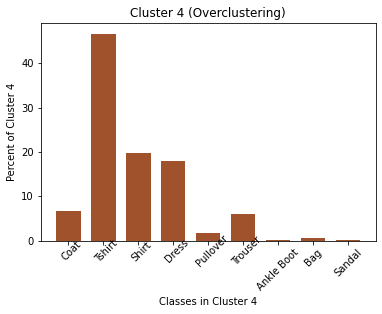

this is class distribution for cluster 5
this is hs for cluster 0.9701383831026948
Number of points of class Bag in cluster 5: 1332 (97.01383831026948)
Number of points of class Tshirt in cluster 5: 9 (0.6554989075018208)
Number of points of class Coat in cluster 5: 8 (0.5826656955571741)
Number of points of class Pullover in cluster 5: 9 (0.6554989075018208)
Number of points of class Shirt in cluster 5: 10 (0.7283321194464676)
Number of points of class Sandal in cluster 5: 5 (0.3641660597232338)


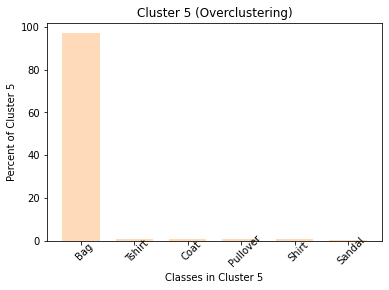

this is class distribution for cluster 6
this is hs for cluster 0.5044432828018819
Number of points of class Shirt in cluster 6: 895 (23.392577104025094)
Number of points of class Coat in cluster 6: 1930 (50.44432828018819)
Number of points of class Tshirt in cluster 6: 58 (1.5159435441714584)
Number of points of class Pullover in cluster 6: 769 (20.099320439100886)
Number of points of class Ankle Boot in cluster 6: 1 (0.026136957658128592)
Number of points of class Trouser in cluster 6: 26 (0.6795608991113434)
Number of points of class Dress in cluster 6: 107 (2.7966544694197593)
Number of points of class Bag in cluster 6: 40 (1.0454783063251438)


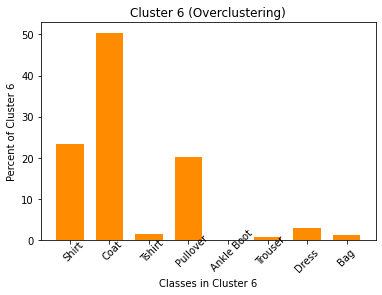

this is class distribution for cluster 7
this is hs for cluster 0.9377958079783637
Number of points of class Bag in cluster 7: 1387 (93.77958079783637)
Number of points of class Coat in cluster 7: 15 (1.0141987829614605)
Number of points of class Dress in cluster 7: 23 (1.555104800540906)
Number of points of class Sandal in cluster 7: 10 (0.676132521974307)
Number of points of class Pullover in cluster 7: 10 (0.676132521974307)
Number of points of class Tshirt in cluster 7: 20 (1.352265043948614)
Number of points of class Shirt in cluster 7: 12 (0.8113590263691683)
Number of points of class Trouser in cluster 7: 1 (0.0676132521974307)
Number of points of class Ankle Boot in cluster 7: 1 (0.0676132521974307)


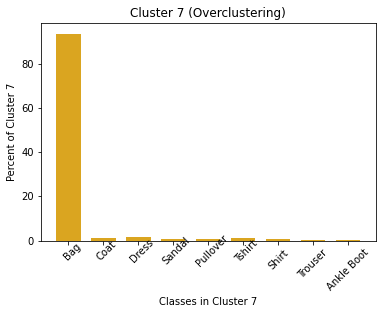

this is class distribution for cluster 8
this is hs for cluster 0.23757828810020876
Number of points of class Bag in cluster 8: 209 (4.3632567849686845)
Number of points of class Pullover in cluster 8: 765 (15.970772442588727)
Number of points of class Dress in cluster 8: 811 (16.931106471816285)
Number of points of class Tshirt in cluster 8: 958 (20.0)
Number of points of class Shirt in cluster 8: 1138 (23.757828810020875)
Number of points of class Trouser in cluster 8: 419 (8.747390396659707)
Number of points of class Coat in cluster 8: 413 (8.622129436325679)
Number of points of class Sandal in cluster 8: 66 (1.3778705636743214)
Number of points of class Ankle Boot in cluster 8: 10 (0.20876826722338201)
Number of points of class Sneaker in cluster 8: 1 (0.020876826722338204)


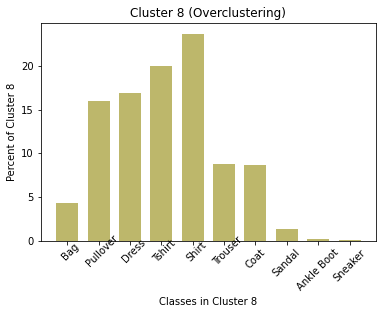

this is class distribution for cluster 9
this is hs for cluster 0.9444182760244937
Number of points of class Ankle Boot in cluster 9: 2005 (94.44182760244937)
Number of points of class Sandal in cluster 9: 102 (4.804521902967498)
Number of points of class Sneaker in cluster 9: 13 (0.6123410268487989)
Number of points of class Bag in cluster 9: 3 (0.1413094677343382)


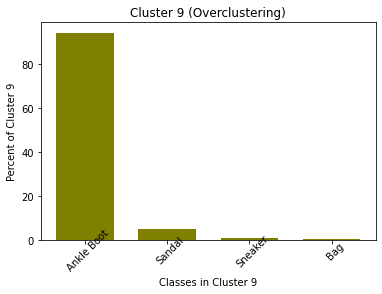

this is class distribution for cluster 10
this is hs for cluster 0.4713740458015267
Number of points of class Coat in cluster 10: 1321 (42.01653944020356)
Number of points of class Pullover in cluster 10: 1482 (47.13740458015267)
Number of points of class Shirt in cluster 10: 315 (10.01908396946565)
Number of points of class Trouser in cluster 10: 19 (0.6043256997455471)
Number of points of class Bag in cluster 10: 3 (0.09541984732824427)
Number of points of class Tshirt in cluster 10: 4 (0.1272264631043257)


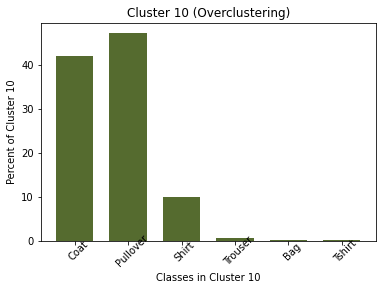

this is class distribution for cluster 11
this is hs for cluster 0.7817690227887215
Number of points of class Ankle Boot in cluster 11: 282 (10.89223638470452)
Number of points of class Bag in cluster 11: 215 (8.304364619544225)
Number of points of class Sandal in cluster 11: 2024 (78.17690227887215)
Number of points of class Tshirt in cluster 11: 2 (0.0772499034376207)
Number of points of class Shirt in cluster 11: 15 (0.5793742757821553)
Number of points of class Sneaker in cluster 11: 46 (1.7767477790652761)
Number of points of class Pullover in cluster 11: 5 (0.19312475859405176)


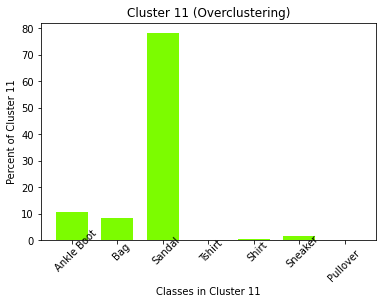

this is class distribution for cluster 12
this is hs for cluster 0.8886010362694301
Number of points of class Sneaker in cluster 12: 3430 (88.86010362694302)
Number of points of class Sandal in cluster 12: 359 (9.300518134715025)
Number of points of class Bag in cluster 12: 51 (1.3212435233160622)
Number of points of class Shirt in cluster 12: 1 (0.025906735751295335)
Number of points of class Ankle Boot in cluster 12: 18 (0.466321243523316)
Number of points of class Tshirt in cluster 12: 1 (0.025906735751295335)


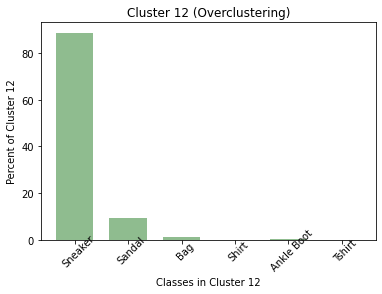

this is class distribution for cluster 13
this is hs for cluster 0.8983833718244804
Number of points of class Ankle Boot in cluster 13: 2723 (89.83833718244803)
Number of points of class Sandal in cluster 13: 119 (3.9260969976905313)
Number of points of class Sneaker in cluster 13: 181 (5.971626525899043)
Number of points of class Bag in cluster 13: 7 (0.23094688221709006)
Number of points of class Dress in cluster 13: 1 (0.03299241174529858)


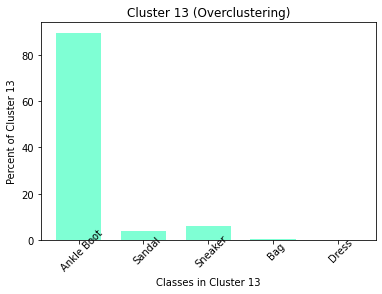

this is class distribution for cluster 14
this is hs for cluster 0.45847916003818007
Number of points of class Ankle Boot in cluster 14: 911 (28.985046134266625)
Number of points of class Sandal in cluster 14: 546 (17.37193763919822)
Number of points of class Sneaker in cluster 14: 1441 (45.84791600381801)
Number of points of class Bag in cluster 14: 242 (7.699650015908367)
Number of points of class Tshirt in cluster 14: 1 (0.03181673560292714)
Number of points of class Shirt in cluster 14: 2 (0.06363347120585428)


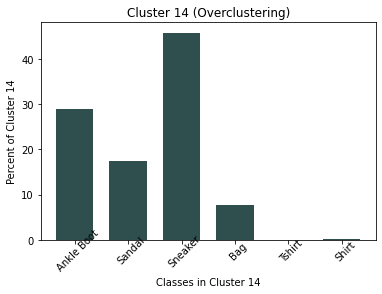

this is class distribution for cluster 15
this is hs for cluster 0.47419171866137266
Number of points of class Dress in cluster 15: 1672 (47.41917186613727)
Number of points of class Coat in cluster 15: 691 (19.59727736812252)
Number of points of class Pullover in cluster 15: 53 (1.5031196823596142)
Number of points of class Trouser in cluster 15: 285 (8.082813386273397)
Number of points of class Tshirt in cluster 15: 450 (12.76233692569484)
Number of points of class Shirt in cluster 15: 361 (10.238230289279638)
Number of points of class Bag in cluster 15: 11 (0.3119682359614294)
Number of points of class Ankle Boot in cluster 15: 2 (0.05672149744753262)
Number of points of class Sandal in cluster 15: 1 (0.02836074872376631)


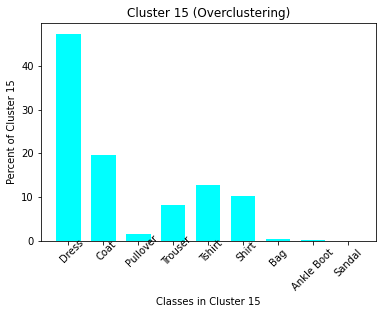

this is class distribution for cluster 16
this is hs for cluster 0.9959574468085106
Number of points of class Trouser in cluster 16: 4681 (99.59574468085106)
Number of points of class Dress in cluster 16: 11 (0.23404255319148937)
Number of points of class Shirt in cluster 16: 3 (0.06382978723404255)
Number of points of class Coat in cluster 16: 4 (0.0851063829787234)
Number of points of class Bag in cluster 16: 1 (0.02127659574468085)


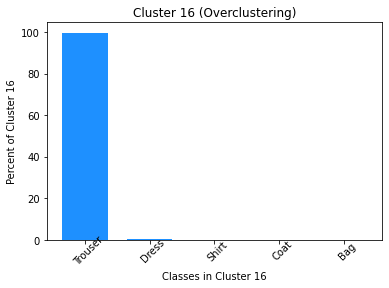

this is class distribution for cluster 17
this is hs for cluster 0.9587884806355511
Number of points of class Pullover in cluster 17: 16 (0.7944389275074478)
Number of points of class Bag in cluster 17: 1931 (95.87884806355511)
Number of points of class Coat in cluster 17: 9 (0.4468718967229395)
Number of points of class Shirt in cluster 17: 36 (1.787487586891758)
Number of points of class Sandal in cluster 17: 2 (0.09930486593843098)
Number of points of class Tshirt in cluster 17: 15 (0.7447864945382324)
Number of points of class Sneaker in cluster 17: 2 (0.09930486593843098)
Number of points of class Ankle Boot in cluster 17: 2 (0.09930486593843098)
Number of points of class Dress in cluster 17: 1 (0.04965243296921549)


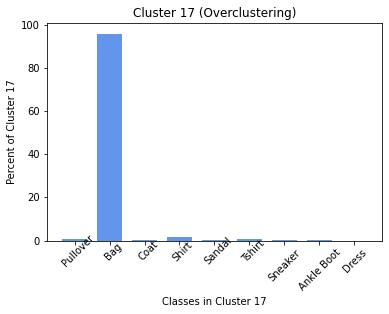

this is class distribution for cluster 18
this is hs for cluster 0.397335236735665
Number of points of class Pullover in cluster 18: 1670 (39.7335236735665)
Number of points of class Bag in cluster 18: 103 (2.450630502022365)
Number of points of class Shirt in cluster 18: 1309 (31.1444206519153)
Number of points of class Coat in cluster 18: 854 (20.318819890554366)
Number of points of class Trouser in cluster 18: 50 (1.1896264572924102)
Number of points of class Tshirt in cluster 18: 134 (3.188198905543659)
Number of points of class Dress in cluster 18: 73 (1.736854627646919)
Number of points of class Ankle Boot in cluster 18: 9 (0.21413276231263384)
Number of points of class Sandal in cluster 18: 1 (0.023792529145848205)


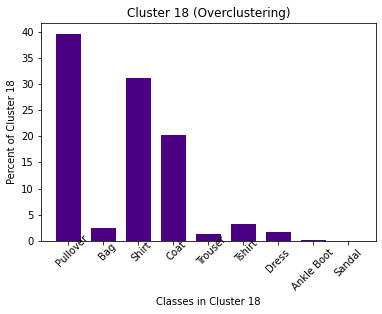

In [ ]:
#class distributions for traditional n clusters
separatedClustersTrad = []
numPredictedClusters = len(np.unique(clusterLabels)) # number of predicted clusters
numActual = len(np.unique(y)) # number of actual ground truth classes
labelDictionary = {0:"Tshirt",1:"Trouser",2:"Pullover",3: "Dress",4 : "Coat",5 : "Sandal",6 : "Shirt",7 : "Sneaker",8 : "Bag",9 : "Ankle Boot"}
legend = {0: 'rosybrown', 1:'silver', 2: 'darkred', 3:'coral', 4:'sienna', 5:'peachpuff', 6: 'darkorange', 7:'goldenrod', 8:'darkkhaki', 9:'olive', 10:'darkolivegreen', 11:'lawngreen', 12:'darkseagreen', 13:'aquamarine', 14:'darkslategray', 15:'cyan', 16:'dodgerblue', 17:'cornflowerblue', 18:'indigo', 19:'fuchsia', 20:'palevioletred'}



lst = calculateHomogeneity(clusterLabels,y)
hsPClusterTrad = lst[0]
print("Average homogeneity for TRADITIONAL clustering: ", mean(lst[0]))

plt.figure(1)
for i in range(numPredictedClusters): #0-n clusters
  classCount = {}
  print("this is class distribution for cluster {}".format(i))
  print("this is hs for cluster {}".format(hsPClusterTrad[i]))
  #now we find in pred indexs of points with label i
  ind = np.where(np.isin(clusterLabels,i))
  separatedClustersTrad.append(ind)
  #with those indexes we find actual values for all of those points in cluster
  actualVals = y[ind] #y is actual labels
  #now we iterate through actual to find counts for each class in cluster
  for a in actualVals:
    if a in classCount:
      classCount[a] += 1
    else:
      classCount[a] = 1
  #now we have counts for each class in cluster
  #now we need to report counts and make plots
  classesPerCluster = []
  percentagePClass = []
  for key in classCount:
    percentage = (classCount[key]/sum(classCount.values()))*100
    print("Number of points of class {} in cluster {}: {} ({})".format(labelDictionary[key],i,classCount[key],percentage))
    classesPerCluster.append(labelDictionary[key])
    percentagePClass.append(percentage)

  plt.subplot()
  plt.xticks(rotation=45, rotation_mode='anchor')
  plt.bar(classesPerCluster,percentagePClass,width=.7, align='center',color = legend[i])
  plt.title("Cluster {} (Overclustering)".format(i))
  plt.xlabel("Classes in Cluster {}".format(i))
  plt.ylabel("Percent of Cluster {}".format(i))
  plt.show()

In [ ]:
print(hsPClusterTrad)

[0.718075422626788, 0.8159974707556118, 0.40983014094687387, 0.8477287268074216, 0.46664645239539115, 0.9701383831026948, 0.5044432828018819, 0.9377958079783637, 0.23757828810020876, 0.9444182760244937, 0.4713740458015267, 0.7817690227887215, 0.8886010362694301, 0.8983833718244804, 0.45847916003818007, 0.47419171866137266, 0.9959574468085106, 0.9587884806355511, 0.397335236735665]


In [ ]:
hsPClusterTrad.sort()
print(hsPClusterTrad)

[0.23757828810020876, 0.397335236735665, 0.40983014094687387, 0.45847916003818007, 0.46664645239539115, 0.4713740458015267, 0.47419171866137266, 0.5044432828018819, 0.718075422626788, 0.7817690227887215, 0.8159974707556118, 0.8477287268074216, 0.8886010362694301, 0.8983833718244804, 0.9377958079783637, 0.9444182760244937, 0.9587884806355511, 0.9701383831026948, 0.9959574468085106]


this is the class distribution for cluster: 0

this is the homogeneity Score for this cluster: 0.916459697448634

Number of points of class Pullover in cluster 0: 101 (2.2804244750508014)
Number of points of class Bag in cluster 0: 4059 (91.6459697448634)
Number of points of class Shirt in cluster 0: 134 (3.0255136599683903)
Number of points of class Trouser in cluster 0: 4 (0.09031384059607135)
Number of points of class Coat in cluster 0: 47 (1.0611876270038383)
Number of points of class Tshirt in cluster 0: 58 (1.3095506886430346)
Number of points of class Dress in cluster 0: 9 (0.20320614134116052)
Number of points of class Sneaker in cluster 0: 2 (0.045156920298035676)
Number of points of class Sandal in cluster 0: 14 (0.3160984420862497)
Number of points of class Ankle Boot in cluster 0: 1 (0.022578460149017838)


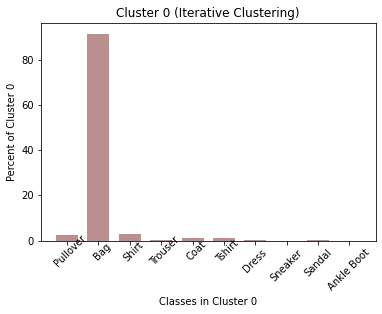

this is the class distribution for cluster: 1

this is the homogeneity Score for this cluster: 0.8123982837697884

Number of points of class Ankle Boot in cluster 1: 5491 (81.23982837697883)
Number of points of class Sneaker in cluster 1: 671 (9.927504068649208)
Number of points of class Sandal in cluster 1: 575 (8.507175617694926)
Number of points of class Bag in cluster 1: 20 (0.2959017606154757)
Number of points of class Tshirt in cluster 1: 1 (0.014795088030773782)
Number of points of class Shirt in cluster 1: 1 (0.014795088030773782)


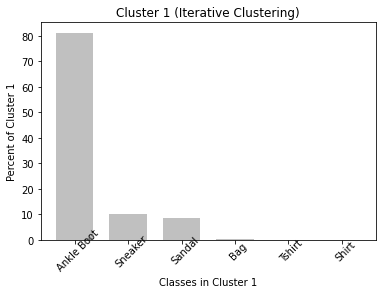

this is the class distribution for cluster: 2

this is the homogeneity Score for this cluster: 0.9933485761795885

Number of points of class Trouser in cluster 2: 4779 (99.33485761795885)
Number of points of class Tshirt in cluster 2: 5 (0.10392849719393059)
Number of points of class Dress in cluster 2: 13 (0.2702140927042195)
Number of points of class Coat in cluster 2: 9 (0.18707129494907504)
Number of points of class Shirt in cluster 2: 5 (0.10392849719393059)


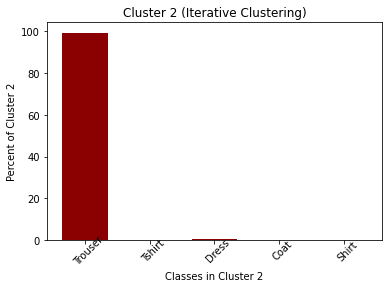

this is the class distribution for cluster: 3

this is the homogeneity Score for this cluster: 0.8003060443764346

Number of points of class Tshirt in cluster 3: 3138 (80.03060443764346)
Number of points of class Shirt in cluster 3: 679 (17.317010966590153)
Number of points of class Dress in cluster 3: 62 (1.5812292782453454)
Number of points of class Pullover in cluster 3: 24 (0.612088752869166)
Number of points of class Bag in cluster 3: 8 (0.204029584289722)
Number of points of class Trouser in cluster 3: 3 (0.07651109410864575)
Number of points of class Ankle Boot in cluster 3: 1 (0.02550369803621525)
Number of points of class Coat in cluster 3: 6 (0.1530221882172915)


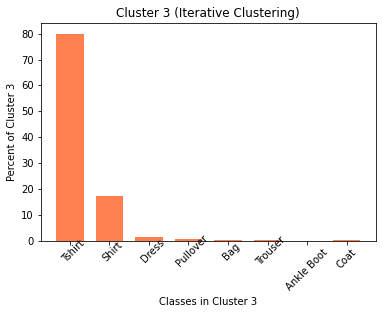

this is the class distribution for cluster: 4

this is the homogeneity Score for this cluster: 0.8105997210599721

Number of points of class Bag in cluster 4: 88 (2.4546722454672243)
Number of points of class Tshirt in cluster 4: 201 (5.606694560669457)
Number of points of class Shirt in cluster 4: 58 (1.6178521617852164)
Number of points of class Dress in cluster 4: 2906 (81.05997210599722)
Number of points of class Coat in cluster 4: 66 (1.8410041841004186)
Number of points of class Trouser in cluster 4: 249 (6.94560669456067)
Number of points of class Ankle Boot in cluster 4: 4 (0.11157601115760112)
Number of points of class Sandal in cluster 4: 5 (0.1394700139470014)
Number of points of class Pullover in cluster 4: 8 (0.22315202231520223)


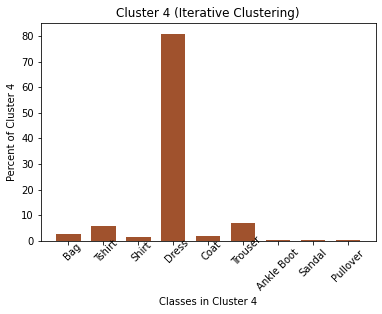

this is the class distribution for cluster: 5

this is the homogeneity Score for this cluster: 0.8342399083882049

Number of points of class Sneaker in cluster 5: 2914 (83.4239908388205)
Number of points of class Sandal in cluster 5: 551 (15.774405954766676)
Number of points of class Bag in cluster 5: 21 (0.6012024048096193)
Number of points of class Ankle Boot in cluster 5: 7 (0.2004008016032064)


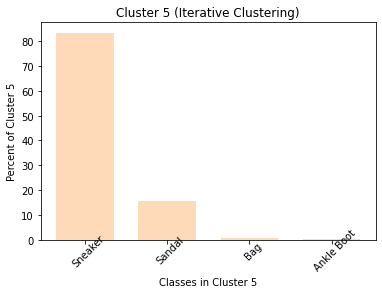

this is the class distribution for cluster: 6

this is the homogeneity Score for this cluster: 0.8185860382392174

Number of points of class Sandal in cluster 6: 1841 (81.85860382392174)
Number of points of class Ankle Boot in cluster 6: 182 (8.092485549132949)
Number of points of class Bag in cluster 6: 147 (6.536238328145842)
Number of points of class Sneaker in cluster 6: 67 (2.9791018230324586)
Number of points of class Shirt in cluster 6: 7 (0.31124944419742107)
Number of points of class Pullover in cluster 6: 3 (0.1333926189417519)
Number of points of class Tshirt in cluster 6: 2 (0.08892841262783459)


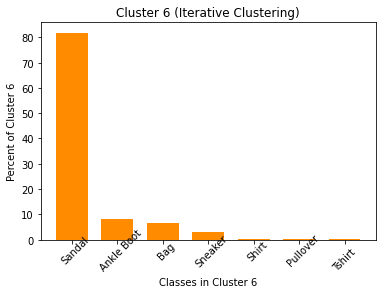

this is the class distribution for cluster: 7

this is the homogeneity Score for this cluster: 0.8537117903930131

Number of points of class Bag in cluster 7: 782 (85.37117903930131)
Number of points of class Dress in cluster 7: 33 (3.602620087336245)
Number of points of class Tshirt in cluster 7: 37 (4.039301310043668)
Number of points of class Shirt in cluster 7: 27 (2.947598253275109)
Number of points of class Sandal in cluster 7: 11 (1.2008733624454149)
Number of points of class Pullover in cluster 7: 9 (0.9825327510917031)
Number of points of class Coat in cluster 7: 13 (1.4192139737991267)
Number of points of class Ankle Boot in cluster 7: 2 (0.21834061135371177)
Number of points of class Trouser in cluster 7: 2 (0.21834061135371177)


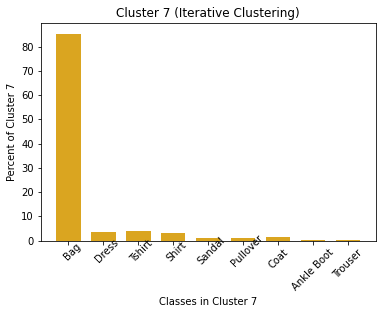

this is the class distribution for cluster: 8

this is the homogeneity Score for this cluster: 0.8088235294117647

Number of points of class Sandal in cluster 8: 1430 (80.88235294117648)
Number of points of class Bag in cluster 8: 32 (1.809954751131222)
Number of points of class Sneaker in cluster 8: 295 (16.68552036199095)
Number of points of class Shirt in cluster 8: 4 (0.22624434389140274)
Number of points of class Tshirt in cluster 8: 1 (0.056561085972850686)
Number of points of class Coat in cluster 8: 1 (0.056561085972850686)
Number of points of class Ankle Boot in cluster 8: 4 (0.22624434389140274)
Number of points of class Pullover in cluster 8: 1 (0.056561085972850686)


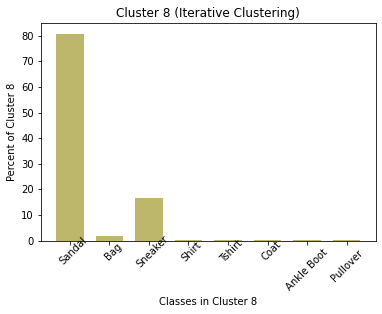

this is the class distribution for cluster: 9

this is the homogeneity Score for this cluster: 0.9450171821305842

Number of points of class Trouser in cluster 9: 275 (94.50171821305841)
Number of points of class Coat in cluster 9: 4 (1.3745704467353952)
Number of points of class Shirt in cluster 9: 5 (1.718213058419244)
Number of points of class Dress in cluster 9: 1 (0.3436426116838488)
Number of points of class Tshirt in cluster 9: 6 (2.0618556701030926)


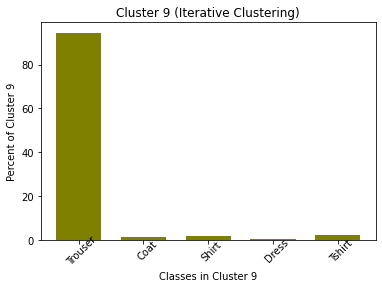

this is the class distribution for cluster: 10

this is the homogeneity Score for this cluster: 0.8542963885429639

Number of points of class Dress in cluster 10: 686 (85.42963885429639)
Number of points of class Trouser in cluster 10: 14 (1.7434620174346203)
Number of points of class Tshirt in cluster 10: 52 (6.47571606475716)
Number of points of class Coat in cluster 10: 20 (2.4906600249066)
Number of points of class Shirt in cluster 10: 28 (3.4869240348692405)
Number of points of class Pullover in cluster 10: 3 (0.37359900373599003)


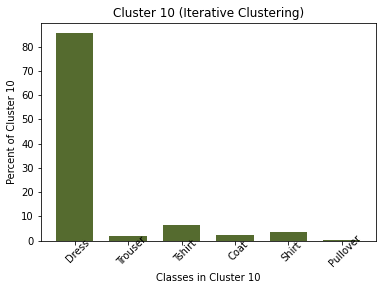

this is the class distribution for cluster: 11

this is the homogeneity Score for this cluster: 0.8328611898016998

Number of points of class Pullover in cluster 11: 588 (83.28611898016997)
Number of points of class Coat in cluster 11: 61 (8.640226628895183)
Number of points of class Shirt in cluster 11: 52 (7.365439093484419)
Number of points of class Bag in cluster 11: 1 (0.141643059490085)
Number of points of class Trouser in cluster 11: 1 (0.141643059490085)
Number of points of class Tshirt in cluster 11: 3 (0.424929178470255)


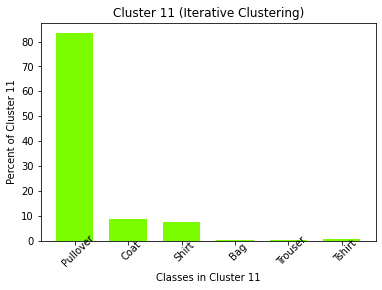

this is the class distribution for cluster: 12

this is the homogeneity Score for this cluster: 0.8748159057437408

Number of points of class Sneaker in cluster 12: 594 (87.48159057437408)
Number of points of class Sandal in cluster 12: 70 (10.309278350515463)
Number of points of class Ankle Boot in cluster 12: 12 (1.7673048600883652)
Number of points of class Bag in cluster 12: 3 (0.4418262150220913)


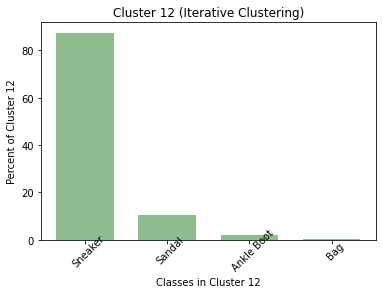

this is the class distribution for cluster: 13

this is the homogeneity Score for this cluster: 0.8084577114427861

Number of points of class Bag in cluster 13: 325 (80.84577114427861)
Number of points of class Sneaker in cluster 13: 18 (4.477611940298507)
Number of points of class Sandal in cluster 13: 31 (7.711442786069651)
Number of points of class Pullover in cluster 13: 5 (1.2437810945273633)
Number of points of class Shirt in cluster 13: 15 (3.731343283582089)
Number of points of class Tshirt in cluster 13: 8 (1.9900497512437811)


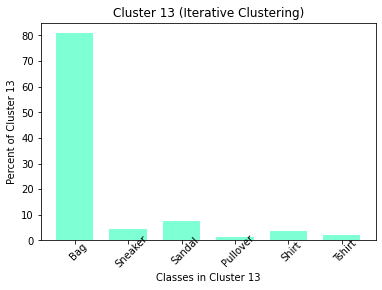

this is the class distribution for cluster: 14

this is the homogeneity Score for this cluster: 0.8038897893030794

Number of points of class Sneaker in cluster 14: 496 (80.38897893030794)
Number of points of class Ankle Boot in cluster 14: 95 (15.39708265802269)
Number of points of class Sandal in cluster 14: 24 (3.889789303079417)
Number of points of class Bag in cluster 14: 2 (0.3241491085899514)


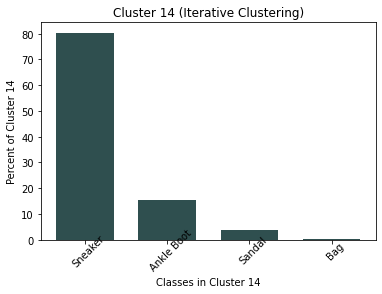

this is the class distribution for cluster: 15

this is the homogeneity Score for this cluster: 0.915068493150685

Number of points of class Trouser in cluster 15: 334 (91.5068493150685)
Number of points of class Dress in cluster 15: 16 (4.383561643835616)
Number of points of class Coat in cluster 15: 2 (0.547945205479452)
Number of points of class Shirt in cluster 15: 2 (0.547945205479452)
Number of points of class Bag in cluster 15: 4 (1.095890410958904)
Number of points of class Tshirt in cluster 15: 6 (1.643835616438356)
Number of points of class Pullover in cluster 15: 1 (0.273972602739726)


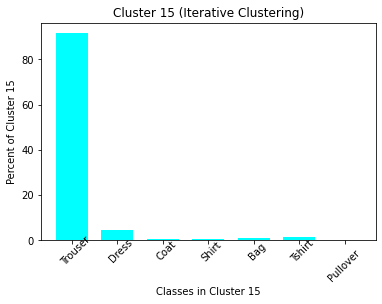

this is the class distribution for cluster: 16

this is the homogeneity Score for this cluster: 0.8173076923076923

Number of points of class Coat in cluster 16: 340 (81.73076923076923)
Number of points of class Pullover in cluster 16: 41 (9.85576923076923)
Number of points of class Shirt in cluster 16: 34 (8.173076923076923)
Number of points of class Bag in cluster 16: 1 (0.2403846153846154)


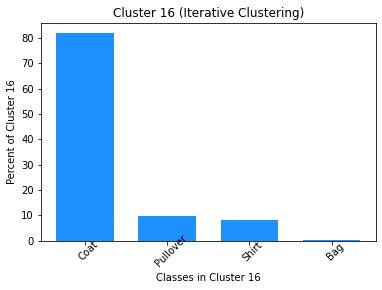

this is the class distribution for cluster: 17

this is the homogeneity Score for this cluster: 0.8566176470588235

Number of points of class Pullover in cluster 17: 233 (85.66176470588235)
Number of points of class Coat in cluster 17: 19 (6.985294117647059)
Number of points of class Shirt in cluster 17: 20 (7.352941176470589)


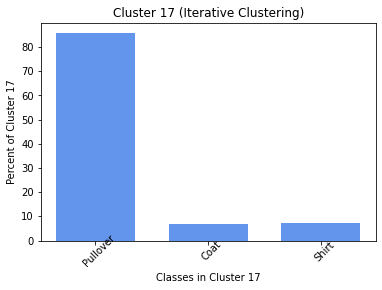

this is the class distribution for cluster: 18

this is the homogeneity Score for this cluster: 0.8007662835249042

Number of points of class Sneaker in cluster 18: 418 (80.07662835249042)
Number of points of class Ankle Boot in cluster 18: 32 (6.130268199233716)
Number of points of class Sandal in cluster 18: 67 (12.835249042145595)
Number of points of class Bag in cluster 18: 5 (0.9578544061302682)


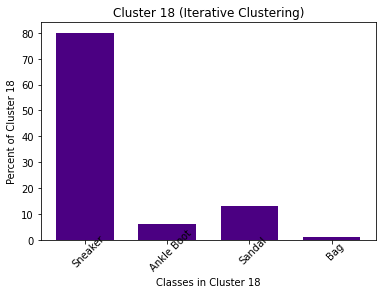

In [ ]:
#Class Distributions for n clusters separated through iterative clustering
clusterIter = 0
labelDictionary = {0:"Tshirt",1:"Trouser",2:"Pullover",3: "Dress",4 : "Coat",5 : "Sandal",6 : "Shirt",7 : "Sneaker",8 : "Bag",9 : "Ankle Boot"}
legend = {0: 'rosybrown', 1:'silver', 2: 'darkred', 3:'coral', 4:'sienna', 5:'peachpuff', 6: 'darkorange', 7:'goldenrod', 8:'darkkhaki', 9:'olive', 10:'darkolivegreen', 11:'lawngreen', 12:'darkseagreen', 13:'aquamarine', 14:'darkslategray', 15:'cyan', 16:'dodgerblue', 17:'cornflowerblue', 18:'indigo', 19:'fuchsia', 20:'palevioletred'}


plt.figure(1)
for cluster in separatedClusters:
  print("this is the class distribution for cluster: {}\n".format(clusterIter))
  print("this is the homogeneity Score for this cluster: {}\n".format(scores[clusterIter]))
  numLabelPerCluster = {}
  for i in cluster:
    label = y[i]
    if label in numLabelPerCluster:
      numLabelPerCluster[label] += 1
    else:
      numLabelPerCluster[label] = 1
  
  classesPerCluster = []
  percentageOfClasses = []
  for key in numLabelPerCluster:
    percentage = (numLabelPerCluster[key]/len(cluster))*100
    print("Number of points of class {} in cluster {}: {} ({})".format(labelDictionary[key],clusterIter,numLabelPerCluster[key],percentage))
    classesPerCluster.append(labelDictionary[key])
    percentageOfClasses.append(percentage)


  plt.subplot()
  plt.xticks(rotation=45, rotation_mode='anchor')
  plt.bar(classesPerCluster, percentageOfClasses,width=.7, align='center',color = legend[clusterIter])
  plt.title("Cluster {} (Iterative Clustering)".format(clusterIter))
  plt.xlabel("Classes in Cluster {}".format(clusterIter))
  plt.ylabel("Percent of Cluster {}".format(clusterIter)) 

  plt.show()

  clusterIter += 1


In [ ]:
print(scores)

[0.916459697448634, 0.8123982837697884, 0.9933485761795885, 0.8003060443764346, 0.8105997210599721, 0.8342399083882049, 0.8185860382392174, 0.8537117903930131, 0.8088235294117647, 0.9450171821305842, 0.8542963885429639, 0.8328611898016998, 0.8748159057437408, 0.8084577114427861, 0.8038897893030794, 0.915068493150685, 0.8173076923076923, 0.8566176470588235, 0.8007662835249042]


In [ ]:
print(mean([0.916459697448634, 0.8123982837697884, 0.9933485761795885, 0.8003060443764346, 0.8105997210599721, 0.8342399083882049, 0.8185860382392174, 0.8537117903930131, 0.8088235294117647, 0.9450171821305842, 0.8542963885429639, 0.8328611898016998, 0.8748159057437408, 0.8084577114427861, 0.8038897893030794, 0.915068493150685, 0.8173076923076923, 0.8566176470588235, 0.8007662835249042]))

0.8503985195933461


In [ ]:
scores.sort()
print(scores)

[0.8003060443764346, 0.8007662835249042, 0.8038897893030794, 0.8084577114427861, 0.8088235294117647, 0.8105997210599721, 0.8123982837697884, 0.8173076923076923, 0.8185860382392174, 0.8328611898016998, 0.8342399083882049, 0.8537117903930131, 0.8542963885429639, 0.8566176470588235, 0.8748159057437408, 0.915068493150685, 0.916459697448634, 0.9450171821305842, 0.9933485761795885]


Number of points of class Shirt in remaining: 4929 (21.434162463037048)
Number of points of class Coat in remaining: 5412 (23.534527743955472)
Number of points of class Bag in remaining: 502 (2.182988345799269)
Number of points of class Tshirt in remaining: 2482 (10.793181422856149)
Number of points of class Pullover in remaining: 4983 (21.668985910593147)
Number of points of class Dress in remaining: 2274 (9.888676291528961)
Number of points of class Sneaker in remaining: 525 (2.283005740128718)
Number of points of class Sandal in remaining: 1381 (6.005392242129066)
Number of points of class Trouser in remaining: 339 (1.4741694207688294)
Number of points of class Ankle Boot in remaining: 169 (0.7349104192033398)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

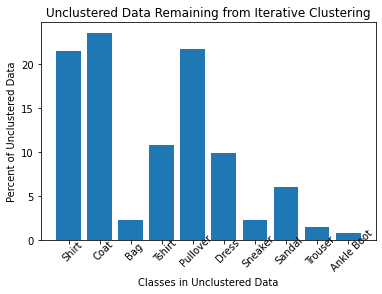

In [ ]:
#Class Distribution for unclustered data from iterative clustering
numLabelsPerClass = {}
for i in remainingPoints:
  label = y[i]
  #print(label)
  if label in numLabelsPerClass:
    numLabelsPerClass[label] += 1
  else:
    numLabelsPerClass[label] = 1

classesInRemaining = []
percentagesPerClassForRemaining = []
for key in numLabelsPerClass:
  percentage = (numLabelsPerClass[key]/len(remainingPoints))*100
  print("Number of points of class {} in remaining: {} ({})".format(labelDictionary[key],numLabelsPerClass[key],percentage))
  classesInRemaining.append(labelDictionary[key])
  percentagesPerClassForRemaining.append(percentage)


plt.bar(classesInRemaining, percentagesPerClassForRemaining,align='center')
plt.title("Unclustered Data Remaining from Iterative Clustering")
plt.xlabel("Classes in Unclustered Data")
plt.ylabel("Percent of Unclustered Data")
plt.xticks(rotation=45, rotation_mode='anchor')

In [ ]:
#Calculating homogeneity of unclustered
labels = y


numLabelsPerClass = {}

for i in remainingPoints:
  label = labels[i]
  #print(label)
  if label in numLabelsPerClass:
    numLabelsPerClass[label] += 1
  else:
    numLabelsPerClass[label] = 1

hsPClass = [] #HS per class in unclustered
for key in numLabelsPerClass:
  homogeneity = (numLabelsPerClass[key]/len(remainingPoints))
  hsPClass.append(homogeneity)

hsWoUnclustered = scores
print(scores)
#print(hsWoUnclustered)
hsWUnclustered = hsWoUnclustered
hsWUnclustered.append(max(hsPClass))
print(hsWUnclustered)


print("this is the max HS for the unclustered data: ",max(hsPClass))
print("this is the avg homogeneity w/ unclustered: {}".format(mean(hsWUnclustered)))

This is cluster 0's pic:
This is an 8


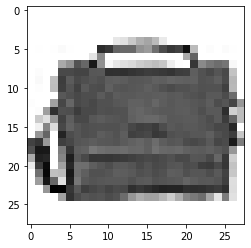

This is cluster 1's pic:
This is an 9


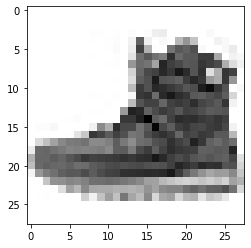

This is cluster 2's pic:
This is an 1


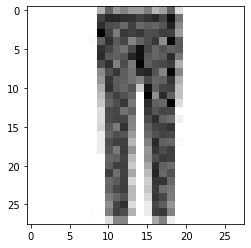

This is cluster 3's pic:
This is an 0


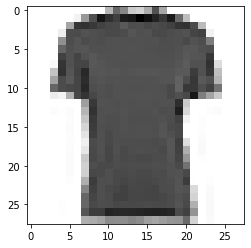

This is cluster 4's pic:
This is an 3


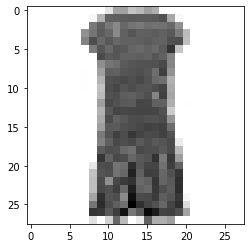

This is cluster 5's pic:
This is an 7


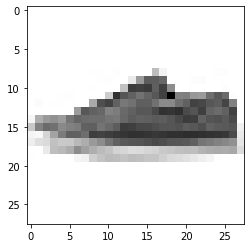

This is cluster 6's pic:
This is an 5


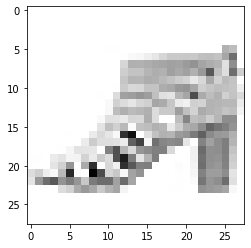

This is cluster 7's pic:
This is an 8


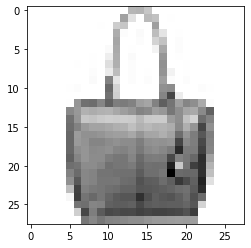

This is cluster 8's pic:
This is an 7


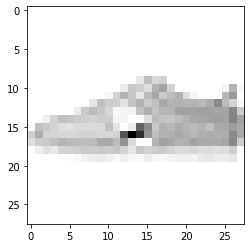

This is cluster 9's pic:
This is an 1


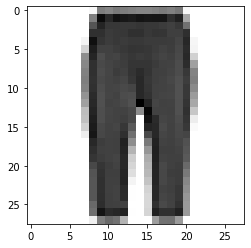

This is cluster 10's pic:
This is an 3


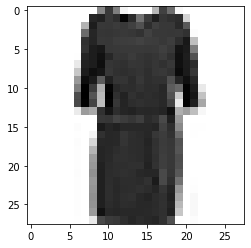

This is cluster 11's pic:
This is an 2


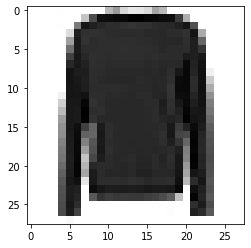

This is cluster 12's pic:
This is an 7


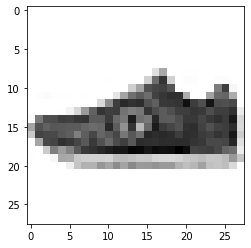

This is cluster 13's pic:
This is an 8


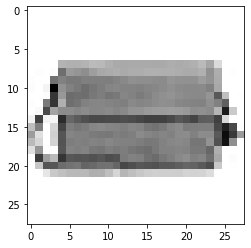

This is cluster 14's pic:
This is an 7


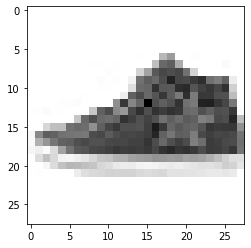

This is cluster 15's pic:
This is an 1


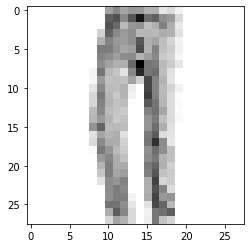

This is cluster 16's pic:
This is an 4


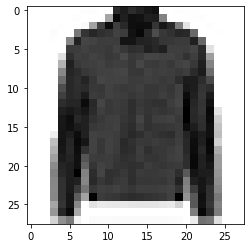

This is cluster 17's pic:
This is an 2


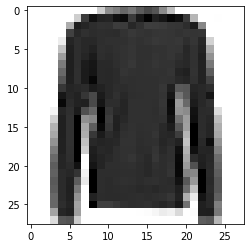

This is cluster 18's pic:
This is an 7


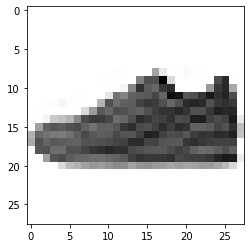

In [ ]:
#printing cluster center pictures for iterative clustering 
X = df.drop(['label'], axis = 1)
pca = PCA(n_components = 76) 
X = pca.fit_transform(X)
closest, _ = pairwise_distances_argmin_min(centers, X)
df = df.drop(['label'], axis=1)
df = df.to_numpy()
clusterIter = 0
for i in closest:
  print("This is cluster {}'s pic:".format(clusterIter))
  print("This is an {}".format(y[i]))
  #print(df[i])
  plt.imshow(df[i].reshape(28, 28), cmap = plt.cm.binary)
  plt.show()
  clusterIter = clusterIter + 1

In [ ]:
#accuracy
print(mean([0.9785553,  0.98372781, 0.99168399, 0.97576531, 0.9595537,  0.9713877,
 0.94,       0.91256831, 0.95762712, 0.82758621, 0.83229814, 0.85815603,
 0.93382353, 0.825,      0.90243902, 0.78082192, 0.85542169, 0.74074074,
 0.92380952]))
#recall
print(mean([0.9785553,  0.98372781, 0.99168399, 0.97576531, 0.9595537,  0.9713877,
 0.94,       0.91256831, 0.95762712, 0.82758621, 0.83229814, 0.85815603,
 0.93382353, 0.825,      0.90243902, 0.78082192, 0.85542169, 0.74074074,
 0.92380952]))
#precision
print(mean([0.98522727, 0.98300074, 0.97446374, 0.98329049, 0.96223776, 0.96861626,
 0.93377483, 0.92265193, 0.94428969, 0.92307692, 0.90540541, 0.90977444,
 0.92028986, 0.94285714, 0.888,      0.91935484, 0.8875,    0.95238095,
 0.94174757]))



0.9026824231578947
0.9026824231578947
0.9393652547368421
